 # <center> Dynamic Stochastic Programming in Python </center>

# Introduction

This notebook demonstrates how dynamic stochastic optimization problems in the area of supply chaing finance can be solved in Python. <br>
For a description of supply chaing finance and detailed specifications of specific instances see __[“Precautionary Replenishment in Financially-Constrained Inventory Systems Subject to Credit Rollover Risk and Supply Disruption,” Sokolinskiy, O., Melamed B., and B. Sopranzetti. Annals of Operations Research, 2018.](https://link.springer.com/article/10.1007/s10479-018-2965-1)__

Table of contents: <br>
1. [Utility functions](#Utility-functions) - specifying the state-space and problem-specific containers for dynamic optimization problems
2. [Problem Types](#Problem-Types) - specific problem types from the Supply Chain and Supply Chain Finance domain
3. [DSP Optimization](#DSP-Optimization) - class for solving DSP problems with Approximate Dynamic Programming functionality
4. [Examples of problem solutions](#Examples-of-problem-solutions) - contains solution of specific DSP problem instances 

For more details on Dynamic and Approximate Stochastic Programming see:
- __[“Dynamic Programming and Optimal Control" by Bertsekas, D.P., Athena Scientific](http://www.athenasc.com/dpbook.html)__
- __["Markov Decision Processes: Discrete Stochastic Dynamic Programming", by Puterman, M.L., Wiley.](https://www.wiley.com/en-us/Markov+Decision+Processes%3A+Discrete+Stochastic+Dynamic+Programming-p-9780471727828)__

### Setting up the environment

In [1]:
import math as m
import numpy as np
import os
import itertools as it
import time
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D, axes3d
from matplotlib import cm
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Utility functions

Numerical solution of dynamic stochastic problems requires a discretization of their state-space. <br>
**stateSpace** class provides this functionality and supports easy iteration over states. It also has methods to convert between indices and states. Finally, **stateSpace** offers support for approximate dynamic programming (ADP) via *aggregation_probs_states()* method, which provides the weights of neighboring aggregate states in the description of a given exact state.

In [11]:
class stateSpace(object):
    '''Sets up the state-space for a dynamic optimization problem: direct product of equidistant 1-dimensional grids
        dims - (list) dimensiality of the state-space [dim_1, dim_2, ..., dim_n]: state-space size = dim_1 * dim_2 * ... * dim_n
        lbounds - (list) lower bounds for each dimension
        incrs   - (list) increments in each dimension
    Feature: SUPPORTS ITERATION (e.g. for s in stateSpace: ...)
    '''
    def __init__(self, dims, lbounds, incrs):
        '''Constructor inputs:
        dims - (list) dimensiality of the state-space [dim_1, dim_2, ..., dim_n]: state-space size = dim_1 * dim_2 * ... * dim_n
        lbounds - (list) lower bounds for each dimension
        incrs   - (list) increments in each dimension
        '''
        self.dims    = dims 
        self.lbounds = lbounds 
        self.ubounds = lbounds + np.multiply(np.array(dims)-1, np.array(incrs)) #upper bounds
        self.incrs   = incrs
        self.strides = list()
        self.ndims  = dims.size
        self.bin_selector = list() #binary selector - used in aggregation_probs_states() to select individual aggregate neighboring states
        stride = 1 #strides are useful for flat indexing - to reach the next state in a desrired dimension - useful when specifying the state as a tuple of indices
        if dims.size > 1:
            for d in dims[:-1]:
                stride = stride * d #calculating strides to reach the next state in each dimension
                self.strides.append(stride)
            for d in range(len(self.dims)):
                self.bin_selector.append([0,1]) #binary selector   
        else:
            self.bin_selector = [[0,1]]
        self.length = self.__len__() #state-space size = dim_1 * dim_2 * ... * dim_n
    
    
    def __len__(self):
        '''state-space size = dim_1 * dim_2 * ... * dim_n'''
        if self.ndims > 1:
            length = 1
            for d in self.dims:
                length = length*d
        else:
            length = np.asscalar(self.dims)
        return length
    
    
    def __getitem__(self, ind):
        '''gets an index TUPLE from a LINEAR one-dimensional index'''
        if ind >= self.length:
            raise IndexError('State index out of range')
        indices = list()
        tmp = ind
        for s in self.strides[::-1]: #getting strides in the reverse order - last stride is the largest
            indices.append(int(tmp/s))
            tmp = tmp - int(tmp/s)*s
        indices.append(tmp)
        return tuple(indices[::-1]) #recovering the ordering of the index
     
        
    def ind_to_state(self, indices):
        '''converts an INDEX tuple to a state VALUES tuple'''
        return self.lbounds + self.incrs*indices

    
    def state_to_ind(self, state):
        '''converst state values tuple to index tuple of the aggregate state that is closest to the exact supplied state'''
        index = np.empty(len(self.dims), dtype = np.int) #pre-allocate np array
        for i,s in enumerate(state):
            if s > self.ubounds[i]: #corner case
                index[i] = self.dims[i]-1
            elif s < self.lbounds[i]: #corner case
                index[i] = 0
            else:
                index[i] = round((s - self.lbounds[i])/self.incrs[i],0) #index of the state that is closest to the exact supplied state
        return tuple(index)
    
    
    def aggregation_probs_states(self, state):
        '''Aggregation probabilities calculation for approximate dynamic programming (ADP) - how an exact state may be represented as a superposition of neigboring aggregate states
        Input:
        State - the state that may not be one of the state-space grid nodes
        Returns:
        indices of neighbouring states and aggregation probabilities that translate the value at the precise state 'State' into a linear combination of values at states belonging to the state-space grid 
        '''
        index_pairs_lu = np.empty((self.ndims,2), dtype = np.int)
        prob_pairs_lu = np.empty((self.ndims,2), dtype = np.float64)
        for i,s in enumerate(state):
            if s > self.ubounds[i]: #corner case - greater than the largest state component in dimension i
                index_pairs_lu[i,0] = self.dims[i]-1
                index_pairs_lu[i,1] = self.dims[i]-1
                prob_pairs_lu[i,0] = 0
                prob_pairs_lu[i,1] = 1
            elif s < self.lbounds[i]: #corner case - lesser than the smallest state component in dimension i
                index_pairs_lu[i,0] = 0
                index_pairs_lu[i,1] = 0
                prob_pairs_lu[i,0] = 0
                prob_pairs_lu[i,1] = 1
            else:
                tmp = (s - self.lbounds[i])/self.incrs[i]
                index_pairs_lu[i,1] = m.ceil(tmp)
                index_pairs_lu[i,0] = m.floor(tmp) 
                prob_pairs_lu[i,1] = tmp - m.floor(tmp)       #upper
                prob_pairs_lu[i,0] = 1 - prob_pairs_lu[i,1]   #lower
            indexes = np.empty((2**self.ndims,self.ndims), dtype = np.int)
            probs = np.empty((2**self.ndims,self.ndims), dtype = np.float64)
            probs_agg = np.empty( 2**self.ndims, dtype = np.float64) 
        for ag_st_counter, itr in enumerate(it.product(*self.bin_selector)):
            for dim_counter, ind in enumerate(zip(range(self.ndims),itr)):
                indexes[ag_st_counter][dim_counter] = index_pairs_lu[ind]
                probs[ag_st_counter][dim_counter] = prob_pairs_lu[ind]
            probs_agg[ag_st_counter] = np.prod(probs[ag_st_counter,:])         
        return indexes, probs_agg
    

    def E_over_agg_probs(self, state, V_array):
        '''Approximate dynamic programming (ADP):
        translating the value at the precise state 'State' into a linear combination (superposition) of values at states belonging to the aggregate state-space grid '''
        indexes, probs_agg = self.aggregation_probs_states(state)
        out = 0
        for ind, prob in enumerate(probs_agg):
            out += prob * V_array[tuple(indexes[ind,])]
        return out

This set of classes supports grouping together <br>
1. independent sources of randomness or
2. separate control components into a single object.

Using a single object for the source of randomness facilitates the construction of the prbability mass function over the state-space, taking into account all sources of randomness (via iteration). <br>
All classes support iteration.

In [12]:
class stridedContainer():
    '''Parent class for controlsCombined and randomnessCombined: provides a shared constructor'''
    def __init__(self, methods, state):
        self.state = state
        if isinstance(methods, list): #multiple functors supplied as a list
            self.functorList = methods
        else: #single functor supplied
            self.functorList = [methods] #conversion to list to enforce the uniform treatment of single and multi-dimensional cases
        self.lengths = np.empty(len(self.functorList), dtype = int)
        for i,ftr in enumerate(self.functorList): #number of different output levels for each functor
            if isinstance(ftr(state), tuple): 
                self.lengths[i] = len(ftr(state)[0]) #if functor returns a tuple (e.g. randomness source returning pmf), take the len of the first element of the tuple
            else:
                self.lengths[i] = len(ftr(state))
        self.length  = np.prod(self.lengths) #size of the control space
        self.strides = list() #strides - utility for obtaining control values via an index (__getitem__ method of descendants)
        stride = 1 
        for i,s in enumerate(self.functorList[:-1]):
            stride = stride * self.lengths[i]
            self.strides.append(stride)
            
    def __getitem__(self, ind):
        raise NotImplementedError()
            
        
class controlsCombined(stridedContainer):
    '''Superposition of individual controls (joint restrictions on valid controls can be included via the cost function)
       Feature: SUPPORTS ITERATION
    '''
    def __init__(self, functorContainerControls, state):
        super().__init__(methods = functorContainerControls, state = state)

        
    def __getitem__(self, ind):
        if ind >= self.length:
            raise IndexError('Shock index out of range')
        indices = list()
        tmp = ind
        for s in self.strides[::-1]:
            indices.append(int(tmp/s))
            tmp = tmp - int(tmp/s)*s
        indices.append(tmp)    
        controls = list()
        for n,i in enumerate(indices[::-1]):
            controls.append(self.functorList[n](self.state)[i])
        return controls    
    
    
class randomnessCombined(stridedContainer):
    '''container for independent 1-dimensional shocks
       Feature: SUPPORTS ITERATION
    '''
    def __init__(self, functorContainerRandomness, state):
        super().__init__(methods = functorContainerRandomness, state = state)
        
    def __getitem__(self, ind):
        if ind >= self.length:
            raise IndexError('Shock index out of range')
        indices = list()
        tmp = ind
        for s in self.strides[::-1]:
            indices.append(int(tmp/s))
            tmp = tmp - int(tmp/s)*s
        indices.append(tmp)    
        shocks = list()
        prob = 1
        for n,i in enumerate(indices[::-1]):
            out_sh, out_p  = self.functorList[n](self.state)
            shocks.append(out_sh[i])
            prob = prob * out_p[i]
        return (prob, shocks)

# Problem Types

Problem types (class inherited from the virtual base **dspProblem**) contain the descriptions of the system dynamics and rewards. They serve as inputs for a dynamic optimizer class **DSP** (see [DSP Optimization](#DSP-Optimization)). A prblem instance must specify:

1. *controls()* - feasible actions given the current state of the system (admissible_control function may specify additional limitations)
2. *randomness()* - source of shocks hitting the system 
3. *transition function()* - how the system state changes based on the current state, applied control and realized shocks
4. *gain()* - reward obtained over the current period of time based on the current state, applied control and realized shocks

In [18]:
from abc import ABCMeta, abstractmethod

class dspProblem(metaclass = ABCMeta):
    '''pure virtual class - for enforcing the DSP problem interface'''
    @abstractmethod
    def control(self, state):
        pass
    
    @abstractmethod
    def admissible_control(self, actions, state):
        pass
    
    @abstractmethod
    def gain(self, state, new_state, actions, shocks):
        pass
    
    @abstractmethod
    def randomness(self, state):
        pass
    
    @abstractmethod
    def transition(self, state, actions, shocks):
        pass

**Basic inventory replenishment policy optimization.** <br>
Optimizing profits. Single line of inventory. Inventory has holding cost. Backorders and lost sales may incur additional costs. <br>
An example of this problem is instantiated and solved in [Basic inventory replenishment policy optimization](#Basic-inventory-replenishment-policy-optimization)

In [23]:
class dspProblemOptimalInventory(dspProblem):
    """This class comprises problem parameters and functions
    It does not contain the actual functionality necessary to solve the problem - it is the input for the DSP class
    Optimizing profits. Single line of inventory. Inventory has holding cost. Backorders and lost sales may incur additional costs.
    
    state[0] - inventory
    shock - random demand for inventory
    control - replenishment order size
    
    MUST have:
    self.disc_factor - float
    self.state_space - stateSpace object
    self.state_space_fine - stateSpace object
    control(self, state)
    admissible_control(self, actions, state)
    gain(self, state, new_state, actions, shocks)
    randomness(self, state)
    transition(self, state, actions, shocks)
    """
    def __init__(self, disc_factor, max_inventory, max_backorders, price_pu, cost_pu, fixed_cost, holding_cost_pu, backord_cost_pu, lost_sales_cost_pu, scale_inv_units = 1, absorbing_state = None):
        '''Constructor:
        disc_factor - (float) discount factor (in (0,1))
        max_inventory - (float) maximum storage capacity - dictates the upper boundary
        max_backorders - (float) maximum number of backorders 
        price_pu - (float) selling price of inventory per unit
        cost_pu - (float) acquisition cost of inventory per unit
        fixed_cost - (float) fixed cost of operation - not variable with inventory
        holding_cost_pu - (float) storage cost per unit of inventory
        backord_cost_pu - (float) cost of backordering - providing customers with a discount if they are forced to wait a period
        lost_sales_cost_pu - (float) cost of lost sales - capturs the effect of custmer dissatisfaction and diminished business reputation
        scale_inv_units - (float) - scaling of inventory units - sets up the coarse grid 
        '''
        self.disc_factor = disc_factor
        self.scale_inv_units = scale_inv_units
        self.max_inventory = max_inventory
        self.max_backorders = - np.abs(max_backorders) #backorders coded as NEGATIVE inventory
        self.fixed_cost = fixed_cost
        self.price = price_pu
        self.cost = cost_pu
        self.holding_cost = holding_cost_pu
        self.backord_cost = backord_cost_pu
        self.lost_sales_cost = lost_sales_cost_pu
        lbound = np.array([self.max_backorders]) #state-space specification
        incr   = np.array([self.scale_inv_units]) #np.array([]) to make comaptible with n-dim case
        dim    = np.array((self.max_inventory - self.max_backorders)/incr[0] + 1, dtype = np.int)
        self.state_space = stateSpace(dim, lbound, incr)
        incr_f   = np.array([1]) #state-space - FINER descritization - np.array([]) to make comaptible with n-dim case
        dim_f    = np.array((self.max_inventory - self.max_backorders)/incr_f[0] + 1, dtype = np.int)
        self.state_space_fine = stateSpace(dim_f, lbound, incr_f)
        self.absorbing_state = absorbing_state
    

    def control(self, state):
        return np.arange(0, max(self.max_inventory - state[0] + 1, 1)) #upper boundary prevents inventory exceeding max_inventory 
        
  
    def admissible_control(self, actions, state):
        return True #this simple problem does not have financial constraints
    
        
    def gain(self, state, new_state, actions, shocks):
        if new_state[0] == self.max_backorders:
            lost_sales = -(state[0] + actions[0] - shocks[0] - self.max_backorders)
        else:
            lost_sales = 0
        if new_state[0] < 0:
            TR = (max(state[0],0) + actions[0])*self.price  #all inventory (if any) is sold and all newly ordered units also sold
        else:
            TR = (max(-state[0],0) + shocks[0])*self.price   #all backorders (if any) are satisfied and all new demand is satisfied
        C = self.fixed_cost + actions[0]*self.cost + self.holding_cost*(max(new_state[0],0)+max(state[0],0))/2 + self.backord_cost*max(-new_state[0],0) + lost_sales*self.lost_sales_cost
        return TR - C
          

    def randomness(self, state):
        shocks = np.array([self.scale_inv_units*i for i in range(1,self.max_inventory+1)])
        probs  = np.ones(len(shocks))/len(shocks)
        return shocks, probs
    

    def transition(self, state, actions, shocks):
        return np.array([max(state[0] + actions[0] - shocks[0], self.max_backorders)])

**Inventory replenishment policy optimization with financing constraints and debt rollover risk.** <br>
Optimizing profits. Single line of inventory. Inventory has holding cost. Backorders and lost sales may incur additional costs.
In addition, there are financial constraints. A credit line may be used for financing inventory replenishments. The size of the credit line depends on the profitability of the company in the previous period.
Rollover risk - credit line be withdrawn.

In [24]:
class dspProblemOptimalInventoryFinancing(dspProblemOptimalInventory):
    """This class comprises problem parameters and functions
    It does not contain the actual functionality necessary to solve the problem - it is the input for the DSP class
    
    Optimizing profits. Single line of inventory. Inventory has holding cost. Backorders and lost sales may incur additional costs.
    In addition, there are financial constraints. A credit line may be used for financing inventory replenishments. The size of the credit line depends on the profitability of the company in the previous period.
    Rollover risk - credit line be withdrawn.
    
    state[0] - inventory
    state[1] - cash
    state[2] - credit line state
    state[3] - profit/loss over the preceeding period
    shocks[0] - random demand for inventory
    shocks[1] - roll over risk - risk of not obtaining financing
    inventory action "-1" is code for initiating voluntary bankruptcy
    
    shocks[0] - random demand for inventory
    shocks[1] - random credit line availability (rollover risk)
    control - replenishment order size OR volunatry bankruptcy
    """
    def __init__(self, disc_factor, max_inventory, max_backorders, price_pu, cost_pu, fixed_cost, holding_cost_pu, backord_cost_pu, lost_sales_cost_pu = 1, scale_inv_units = 1, absorbing_state = None,
                 aggreg_level = 2.5,
                 comp_balance = 3, cr_line_sens = 0.5, max_cred_multipl = 5, max_cash = 20, liquid_price = 0.75, rate_borrow = 0.025, rate_earn = 0, lower_profits_sens_bound = -2.5, upper_profits_sens_bound = -2.5,
                 ror_flag = True, probs_ror_existing_line = [0.25, 0.75], probs_ror_no_line = [0.50, 0.50]):
        '''
        Inputs:
        disc_factor - (float) discount factor (in (0,1))
        INVENTORY SIDE PARAMETERS:
        max_inventory - (float) maximum storage capacity - dictates the upper boundary
        max_backorders - (float) maximum number of backorders 
        price_pu - (float) selling price of inventory per unit
        cost_pu - (float) acquisition cost of inventory per unit
        fixed_cost - (float) fixed cost of operation - not variable with inventory
        holding_cost_pu - (float) storage cost per unit of inventory
        backord_cost_pu - (float) cost of backordering - providing customers with a discount if they are forced to wait a period
        lost_sales_cost_pu - (float) cost of lost sales - capturs the effect of custmer dissatisfaction and diminished business reputation
        scale_inv_units - (float) - scaling of inventory units - sets up the coarse grid 
        FINANCE SIDE PARAMETERS:
        comp_balance - (float) compensating balance - impacts the size of the credit line
        cr_line_sens - (float) sensitivity of the credit line size to proftis/losses incurred over the previous period
        max_cred_multipl - (float) maximum credit line multiplier
        max_cash - (float) max allowed cash holdings - all excess cash is paid out to owners (stockholders/parent company)
        liquid_price - (float) price per unit if potential bankruptcy forces (partial) liquidation of inventory
        rate_borrow - (float) cost of borrowing
        rate_earn - (float) return on held cash balances
        lower_profits_sens_bound - (float) impacts HOW the size of the credit line depends on proftis/losses incurred over the previous period - caps the effect of previous LOSSES
        upper_profits_sens_bound - (float) impacts HOW the size of the credit line depends on proftis/losses incurred over the previous period - caps the effect of previous GAINS
        ror_flag - (bool) indicator for the presence of rollover risk 
        probs_ror_existing_line - (list of floats) [probability_of_losing_credit, probability_of_maintaining_credit] 
        probs_ror_no_line - (list of floats) [probability_of_remaining_without_credit, probability_of_obtaining_credit]
        '''
        super().__init__(disc_factor, max_inventory, max_backorders, price_pu, cost_pu, fixed_cost, holding_cost_pu, backord_cost_pu, lost_sales_cost_pu, scale_inv_units, absorbing_state)
        self.comp_balance = comp_balance
        self.cr_line_sens = cr_line_sens
        self.max_cred_multipl = max_cred_multipl #maximum possible credit multiplier - ACTUAL is endogenous
        self.bankruptcy_cost = - self.comp_balance/self.disc_factor
        self.max_cash = max_cash
        self.max_debt = - self.comp_balance*self.max_cred_multipl
        self.liquid_price = liquid_price/self.scale_inv_units
        self.rate_borrow = rate_borrow
        self.rate_earn = rate_earn
        if ror_flag:
            self.probs_ror_existing_line = probs_ror_existing_line
            self.probs_ror_no_line = probs_ror_no_line
        else:
            self.probs_ror_existing_line = [0, 1]
            self.probs_ror_no_line = [1, 0]
        lbounds = np.array([self.max_backorders, self.max_debt, 0, lower_profits_sens_bound]) #specifying adequate state-space discretization
        incrs = np.array([aggreg_level*self.scale_inv_units, aggreg_level, 1, upper_profits_sens_bound])
        dims = np.array([(self.max_inventory - self.max_backorders)/incrs[0] + 1, (self.max_cash - self.max_debt)/incrs[1]+1, 2, 3], dtype = np.int)
        self.state_space = stateSpace(dims, lbounds, incrs)
        incrs_f = np.array([self.scale_inv_units, 1, 1, upper_profits_sens_bound]) #finer grid - cash dimension - not aggregated
        dims_f = np.array([(self.max_inventory - self.max_backorders)/incrs_f[0] + 1, (self.max_cash - self.max_debt)/incrs_f[1]+1, 2, 3], dtype = np.int)
        self.state_space_fine = stateSpace(dims_f, lbounds, incrs_f)   
        self.bankruptcy_state = lbounds
        self.randomness = [self.demand_randomness, self.credit_randomness]
          
    def inventory_control(self, state):
        if state[2] == 1: #avaliable credit line
            credit_mult = 1 + (self.max_cred_multipl - 1)*np.exp(self.cr_line_sens*state[3])/(1+np.exp(self.cr_line_sens*state[3]))
        else: #no external financing
            credit_mult = 1
        return np.arange(-1, max(min(self.max_inventory - state[0], m.floor((state[1]+self.comp_balance*credit_mult)/self.cost))+1, 1) ) #inventory action "-1" is code for initiating voluntary bankruptcy
        
    
    def admissible_control(self, actions, state):
        return True
    
        
    def gain(self, state, new_state, actions, shocks):
        if (state == self.bankruptcy_state).all(): #starting from bankruptcy
            return 0
        elif (new_state == self.bankruptcy_state).all(): #entering bankruptcy
            return self.bankruptcy_cost
        else:
            return new_state[1] - state[1] #change in cash balances
          
        
    def demand_randomness(self, state):
        shocks = np.array([self.scale_inv_units*i for i in range(1,26)])
        probs = np.ones(len(shocks))/len(shocks)
        return shocks, probs
    
    def credit_randomness(self, state):
        shocks = np.array([0,1], dtype = np.float64)
        if state[2] == 1:
            probs = np.array(self.probs_ror_existing_line, dtype = np.float64)
        else:
            probs = np.array(self.probs_ror_no_line, dtype = np.float64)  
        return shocks, probs 
    
        
    def transition(self, state, actions, shocks):
        if (state == self.bankruptcy_state).all(): #bankruptcy is an absorbing state
            return state 
        new_state = np.empty(4)
        if actions[0] == -1: #inventory action "-1" is code for initiating voluntary bankruptcy
            new_state = self.bankruptcy_state
            return new_state
        #################  inventory dimension  #################
        new_state[0] = max(state[0] + actions[0] - shocks[0], self.max_backorders)
        if new_state[0] == self.max_backorders:
            lost_sales = -(state[0] + actions[0] - shocks[0] - self.max_backorders)
        else:
            lost_sales = 0
        #################  cash dimension  ################# 
        if new_state[0] < 0:
            TR = (max(state[0],0) + actions[0])*self.price  #all inventory (if any) is sold and all newly ordered units also sold
        else:
            TR = (max(-state[0],0) + shocks[0])*self.price   #all backorders (if any) are satisfied and all new demand is satisfied
        C = self.fixed_cost + actions[0]*self.cost + self.holding_cost*(max(new_state[0],0)+max(state[0],0))/2 + self.backord_cost*max(-new_state[0],0) + lost_sales*self.lost_sales_cost
        C += self.rate_borrow*max(-state[1],0) - self.rate_earn*max(state[1],0)     
        new_state[1] = TR - C + state[1]
        new_state[2] = shocks[1] #credit line availability
        new_state[3] = new_state[1] - state[1] #profit/loss over the period
        if state[2] == 1:
            credit_mult = 1 + (self.max_cred_multipl - 1)*np.exp(self.cr_line_sens*state[3])/(1+np.exp(self.cr_line_sens*state[3]))
        else:
            credit_mult = 1 
        trigger_0 = - self.comp_balance * credit_mult #first potential bankruptcy trigger - bankruptcy may still be prevented via sales of inventory
        if new_state[1] < trigger_0:
            if new_state[0] > 0 and new_state[1] + self.liquid_price*new_state[0] > trigger_0: #bankruptcy IS prevented via sales of inventory
                forced_liquidation = m.ceil((-new_state[1]+trigger_0)/self.liquid_price) #forced liquidation of inventory
                new_state[0] = new_state[0] - forced_liquidation 
                new_state[1] = new_state[1] + forced_liquidation*self.liquid_price
                new_state[3] = new_state[1] - state[1]
            else: #bankruptcy CANNOT be prevented via sales of inventory
                new_state = self.bankruptcy_state
        return new_state

# DSP Optimization

Solution uses the value iteration algorithm based on the Bellman equation, see: <br>
1. __[“Dynamic Programming and Optimal Control" by Bertsekas, D.P., Athena Scientific](http://www.athenasc.com/dpbook.html)__
2. __[“Precautionary Replenishment in Financially-Constrained Inventory Systems Subject to Credit Rollover Risk and Supply Disruption,” Sokolinskiy, O., Melamed B., and B. Sopranzetti. Annals of Operations Research, 2018.](https://link.springer.com/article/10.1007/s10479-018-2965-1)__
3. __[wikipedia - Value iteration](https://en.wikipedia.org/wiki/Markov_decision_process#Value_iteration)__

In [31]:
class DSP(object):
    '''
    Class containing the dynamic stochastic optimization functionality - approximate dynamic programming (ADP)
    '''
    def __init__(self, dspProblemInstance):
        self.dspProblemInst = dspProblemInstance #ensures the contraction property of the mapping
        self.V = np.zeros(self.dspProblemInst.state_space.dims, dtype = np.float64) #pre-allocating: current estimate of problem value function - COARSE grid
        self.V_prev = np.zeros(self.dspProblemInst.state_space.dims, dtype = np.float64) #pre-allocating: previous estimate of problem value function - COARSE grid
        self.data_type_controls = list()
        if not isinstance(self.dspProblemInst.control, list): #if there is a single control - create a list containing this control - puts 1dim case in the more general n-dim framework
            listOfControls = [self.dspProblemInst.control]
        for fc in listOfControls:
            self.data_type_controls.append((fc.__name__, np.float64)) #creates a datatype to pre-allocate a numpy array of a custom datatype
        self.A = np.zeros(self.dspProblemInst.state_space.dims, dtype = self.data_type_controls) #pre-allocating: current optimal policy estimate (actions for each state)
        self.A_prev = np.zeros(self.dspProblemInst.state_space.dims, dtype = self.data_type_controls) #pre-allocating: previous optimal policy estimate (actions for each state)
        self.V_fine = np.zeros(self.dspProblemInst.state_space_fine.dims, dtype = np.float64) #pre-allocating: current estimate of problem value function - FINE grid
        self.V_prev_fine = np.zeros(self.dspProblemInst.state_space_fine.dims, dtype = np.float64) #pre-allocating: previous estimate of problem value function - FINE grid
        self.A_fine = np.zeros(self.dspProblemInst.state_space_fine.dims, dtype = self.data_type_controls) #pre-allocating: current optimal policy estimate (actions for each state) - FINE grid

        
    def randomness(self, state):
        '''integrating individual sources of randomness (functors) into a single object'''
        return randomnessCombined(self.dspProblemInst.randomness, state)
    
    def controls(self, state):
        '''integrating individual controls (functors) into a single object'''
        return controlsCombined(self.dspProblemInst.control, state)
    

    def expected_gain(self, state, actions, st_sp_flag = 'agg'):
        '''Expected reward over a period of time - starting from state "State" and applying controls "actions"
        State - (state object) - initial state
        actions - list - applied controls
        st_sp_flag - {'Agg', ''Lookahead'}: 'agg' - default optimization - state values from COARSE state-space grid, 'lookahead' - post-optimization - state values from FINE state-space grid
        '''
        if (state == self.dspProblemInst.absorbing_state).all():
            return 0 #no period gain in an absorbing state
        if st_sp_flag == 'agg':
            V_grid = self.V_prev #using the aggregate (coarse) grid => self.stateSpace.E_over_agg_probs delivers substantial aggregation
            state_space = self.dspProblemInst.state_space
        elif st_sp_flag == 'lookahead':
            V_grid = self.V_prev_fine #using the fine grid => self.stateSpace.E_over_agg_probs delivers minimal aggregation (if any)
            state_space = self.dspProblemInst.state_space_fine
        else:
            raise
        out = 0
        for S in self.randomness(state): #iterating over the randomness source produces a pair (prob, shock)
            new_state = self.dspProblemInst.transition(state, actions, S[1])
            out = out + S[0]*( self.dspProblemInst.gain(state, new_state, actions, S[1]) + state_space.E_over_agg_probs(new_state, V_grid) )
        return self.dspProblemInst.disc_factor * out
    

    def optimize_at_state(self, state_ind, st_sp_flag = 'agg'):
        if st_sp_flag == 'agg':
            state = self.dspProblemInst.state_space.ind_to_state(state_ind) #state index is for coarse state-space
        elif st_sp_flag == 'lookahead':
            state = self.dspProblemInst.state_space_fine.ind_to_state(state_ind) #state index is for fine state-space
        else:
            raise
        E_opt = -float('inf') #optimal value
        C_opt = None #optimal control
        for c in self.controls(state):
            if self.dspProblemInst.admissible_control(c, state) == True:
                expected_val = self.expected_gain(state, c, st_sp_flag)
                if(expected_val > E_opt):
                    E_opt = expected_val #update current estimates of optimal values
                    C_opt = c
        return E_opt, tuple(C_opt) #tuple - needed to assign to a numpy array with a custom datatype
    
    
    def value_iteration_step(self):
        '''execture a single value iteration step'''
        for i,s in enumerate(self.dspProblemInst.state_space):
            self.V[s], self.A[s] = self.optimize_at_state(s)
        return self.V
  

    def set_fine_grid_value(self):
        '''creates a fine value grid based on a coarse value grid and aggregation probabilities'''
        for s in self.dspProblemInst.state_space_fine:
            state = self.dspProblemInst.state_space_fine.ind_to_state(s)
            self.V_prev_fine[s] = self.dspProblemInst.state_space.E_over_agg_probs(state, self.V)
      
    
    def one_step_lookahead(self):
        '''one-step lookahead preforms an exact value iteration step with a fine (not coarse) grid - expensive becuase finer grids'''
        self.set_fine_grid_value()
        for i,s in enumerate(self.dspProblemInst.state_space_fine):
            self.V_fine[s], self.A_fine[s] = self.optimize_at_state(s, 'lookahead')
        return self.V_fine 

    
    def solution(self, max_iter = 50, eps = 0.1, policy_chg_patience = 50, lookahead_flag = True, verbose = False):
        ini_time = time.time()
        num_pol_chg = np.empty(policy_chg_patience, dtype = np.float64)
        for i,j in zip(range(max_iter), it.cycle(range(policy_chg_patience))):
            self.V_prev = self.V.copy()
            self.A_prev = self.A.copy()
            self.value_iteration_step()
            d = np.max(abs(self.V-self.V_prev))        
            num_pol_chg[j] = np.sum(self.A != self.A_prev)
            if verbose:
                print('Iteration ', i+1, ' processed. Max absolute improvement is: ', d, '\nNum action changes: ', num_pol_chg[j], '\n'*2)
            if d < eps or np.sum(num_pol_chg) == 0:
                break
        if lookahead_flag:
            self.one_step_lookahead()

# Examples of problem solutions

## Basic inventory replenishment policy optimization

In [34]:
dspProblem = dspProblemOptimalInventory(disc_factor = 0.95, max_inventory = 25, max_backorders = 5,
                                        price_pu = 2, cost_pu = 1, fixed_cost = 0, holding_cost_pu = 0.75, backord_cost_pu = 0.25, lost_sales_cost_pu = 1.0, scale_inv_units = 1)


optimizer = DSP(dspProblem)
optimizer.solution(max_iter = 50, eps = 1, policy_chg_patience = 50, lookahead_flag = True, verbose = False)

Text(0.5,0.98,'Optimization of Supply Chain')

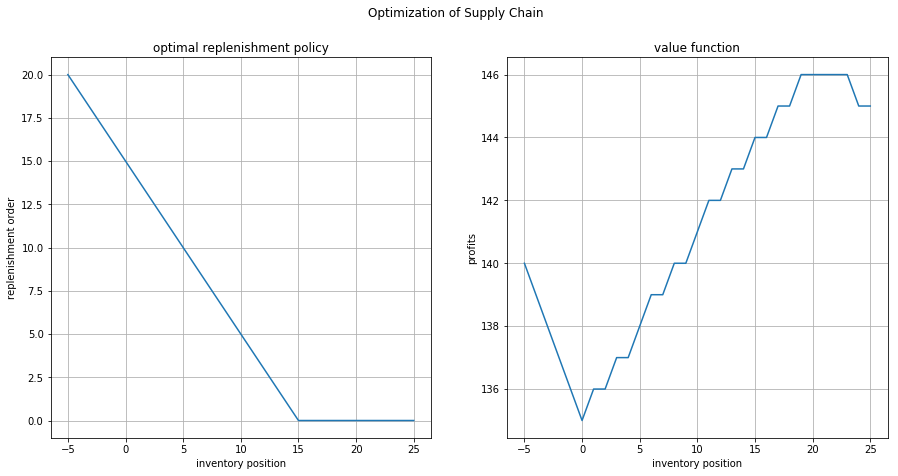

In [35]:
V = optimizer.V_fine.astype(np.int) #extract firm profit estimates as a function of its state
optimalPolicy = optimizer.A_fine.astype(np.int) #extract optimal policy: replenishment action as a function of state
x_range = np.squeeze(np.array([dspProblem.state_space_fine.ind_to_state(s) for s in dspProblem.state_space_fine]))
fig, (axA, axV) = plt.subplots(1, 2, figsize = [15, 7])
axA.plot(x_range, optimalPolicy)
axA.set(xlabel='inventory position', ylabel = 'replenishment order', title = 'optimal replenishment policy')
axA.grid()
axV.plot(x_range, V)
axV.set(xlabel='inventory position', ylabel = 'profits', title = 'value function')
axV.grid()
fig.suptitle('Optimization of Supply Chain')

In [36]:
dspProblemFSC = dspProblemOptimalInventoryFinancing(disc_factor = 0.95, max_inventory = 25, max_backorders = 5, price_pu = 2,
                                        cost_pu = 1, fixed_cost = 0, holding_cost_pu = 0.5, backord_cost_pu = 0.75, lost_sales_cost_pu = 0, ror_flag = True, scale_inv_units = 1)


optimizer_2 = DSP(dspProblemFSC)
optimizer_2.solution(max_iter = 15, eps = 5, policy_chg_patience = 10, lookahead_flag = True, verbose = True)

Iteration  1  processed. Max absolute improvement is:  18.971500000000002 
Num action changes:  744.0 


Iteration  2  processed. Max absolute improvement is:  11.507216144999989 
Num action changes:  592.0 


Iteration  3  processed. Max absolute improvement is:  8.323767328080613 
Num action changes:  144.0 


Iteration  4  processed. Max absolute improvement is:  7.486525687503438 
Num action changes:  38.0 


Iteration  5  processed. Max absolute improvement is:  7.067068246872125 
Num action changes:  12.0 


Iteration  6  processed. Max absolute improvement is:  6.710623502899004 
Num action changes:  2.0 


Iteration  7  processed. Max absolute improvement is:  6.374857696253521 
Num action changes:  1.0 


Iteration  8  processed. Max absolute improvement is:  6.055978917276725 
Num action changes:  3.0 


Iteration  9  processed. Max absolute improvement is:  5.753101272810113 
Num action changes:  0.0 


Iteration  10  processed. Max absolute improvement is:  5.46540609013328

Plotting the results for the scenario in which the credit line is available and its size corresponds to the firm breaking even in the previous reporting period.

Text(0.5,0.98,'Optimization of Supply Chain with Vulnerable Financing')

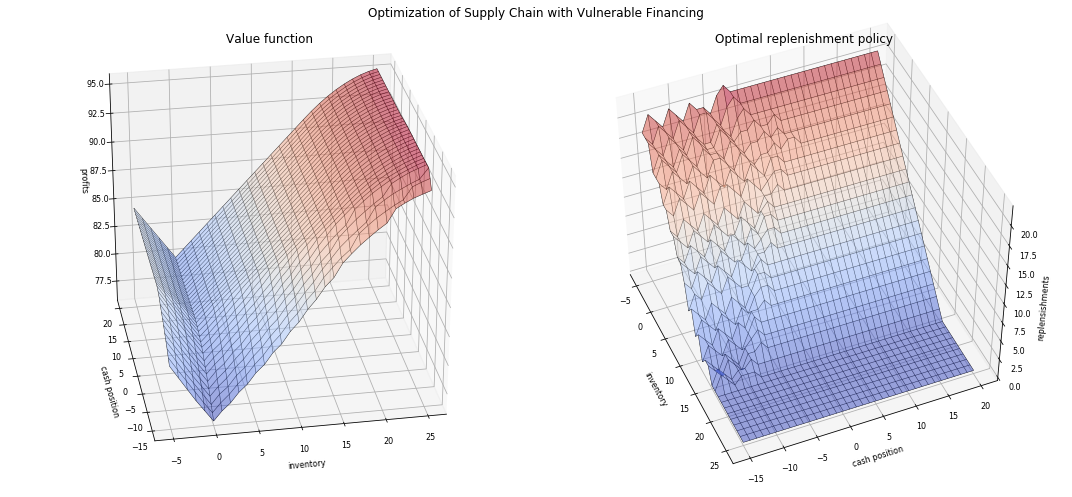

In [57]:
A = optimizer_2.A_fine[:,:,1,0].astype(np.int) #available line of credit s[2] = 1, breaking-even in the previous period s[3] = 0
V = optimizer_2.V_fine[:,:,1,0].astype(np.float)
inv_range = np.unique(np.squeeze(np.array([dspProblemFSC.state_space_fine.ind_to_state(s)[0] for s in dspProblemFSC.state_space_fine]))) #inventory grid
usd_range = np.unique(np.squeeze(np.array([dspProblemFSC.state_space_fine.ind_to_state(s)[1] for s in dspProblemFSC.state_space_fine]))) #cash position grid
inv_range, usd_range = np.meshgrid(inv_range, usd_range)

fig = plt.figure(figsize = (15,7))
ax = fig.add_subplot(121, projection = '3d')
ax.plot_wireframe(inv_range.T, usd_range.T, V, color = 'black', linewidth = 0.5)
ax.plot_surface(inv_range.T, usd_range.T, V, alpha = 0.5, cmap = cm.coolwarm)
ax.view_init(elev = 30, azim = -100)
ax.set_xlabel('inventory', fontsize = 8)
ax.set_ylabel('cash position', fontsize = 8)
ax.set_zlabel('profits', fontsize = 8)
ax.tick_params(labelsize = 8)
ax.set(title = 'Value function')
ax2 = fig.add_subplot(122, projection = '3d')
ax2.plot_wireframe(inv_range.T, usd_range.T, A, color = 'black', linewidth = 0.5)
ax2.plot_surface(inv_range.T, usd_range.T, A, alpha = 0.5, cmap = cm.coolwarm)
ax2.view_init(elev = 49, azim = -23)
ax2.set_xlabel('inventory', fontsize = 8)
ax2.set_ylabel('cash position', fontsize = 8)
ax2.set_zlabel('replensishments', fontsize = 8)
ax2.tick_params(labelsize = 8)
ax2.set(title = 'Optimal replenishment policy')
plt.tight_layout()
fig.suptitle('Optimization of Supply Chain with Vulnerable Financing')

## Postscript: on parallizing the implementation in IPython parallel

Since the value function may be updated **asynchronously**, this code may be parallelized by running identical DSP problems in parallel. Algo: <br>
1. parallel execute *value_iteration_step()*
2. broadcast updates of the value function estimate *V*
3. check for convergence - if not converged - go to Step 1

Implementation using *IPython parallel*: package functionality in a module, import on all engines, run algo. 